In [1]:
%load_ext autoreload
%autoreload 2

import os
import random

import numpy as np
import torch
import scipy.io

import experiment.mRNN as mRNN
import experiment.stim as stim
import experiment.utils as utils


BASE_DIR = os.path.join('michaels', 'Networks')

# Options are M and Z (These are the two monkeys in
# the experiment and I made separate networks for each of their kinematics)
monkey = 'M' 
data_folder =  os.path.join(BASE_DIR, monkey)

# This variable specifies the non-linearity used in the Hidden layer. Input and Output layers are Linear
activation_type = 'recttanh' # Options are recttanh or rectlinear
# This variable specifies the architecture (Figure 5).
# In order from left to right in Figure 5 we have: CNN, Feedforward, LabeledLine-In, LabeledLine-Out, Ball, Sparse
input_name = 'CNN' # Options are CNN, Feedforward, LabeledLine-In, LabeledLine-Out, Ball, Sparse
# This variable specifies the firing rate penalty hyper-parameter (Equation 5)
FR = '1e-3' # Options are 0, 1e-3, 1e-2, 1e-1
# This variable specifies the input/output weight penalty (Equation 6)
IO = '1e-5' # Options are 0, 1e-5, 1e-4, 1e-3
# This variable specifies the sparsity of the connections between modules (most results use 1e-1)
sparsity = '1e-1' # Options are 1e-2, 1e-1, 1e0
# This variable specifies runs with different random initializations of each network
repetition = '1' # Options are 1, 2, 3, 4

network_dir = "-".join([activation_type, input_name, FR, IO, sparsity, repetition])
network_path = os.path.join(data_folder, os.path.join(network_dir, network_dir))
network_data = scipy.io.loadmat(network_path, simplify_cells=True)

print(network_path)


michaels/Networks/M/recttanh-CNN-1e-3-1e-5-1e-1-1/recttanh-CNN-1e-3-1e-5-1e-1-1


Each file contains the necessary information to reproduce one network.

For all networks each time step (dt) represents 10 ms, so the value of tau used in Equation 1 is 10, which represents a 100ms time constant.

The following variables correspond to the elements of Equation 1 and 2:
* B - Input weight matrix
* J - Hidden unit weight matrix
* W - Output weight matrix
* bx - Bias for hidden units
* bz - Bias for output
* x0 - Initial activation for hidden units (not included in the equations)

For each network, I included the input and output signals for a single recording session (~500 trials). Each monkey had 10 recording sessions, so I can send you more data if necessary!
* inp - Inputs for the network. Each entry is one trial and has size Inputs x Time.
* targ - Output targets for the network. Each entry is one trial and has size Outputs x Time.

* trialInfo contains some information about each trial and is size Trial x Dim.
 * Dim 1 - What object was presented on this trial (numbering of objects matches Figures 1-2 in Schaffelhofer & Scherberger, 2016, eLife).
 * Dim 2 - What time the object was lit up (lasts for 70 time steps).
 * Dim 3 - When the monkey was cued to move (flashing of the fixation light).
 * Dim 4 - When the monkey's hand started moving toward the object. For the purpose of this project all trials end 400 ms after the hand started moving.


In [2]:
rnn = mRNN.MichaelsRNN(init_data_path=network_path)

torch.Size([300, 300])


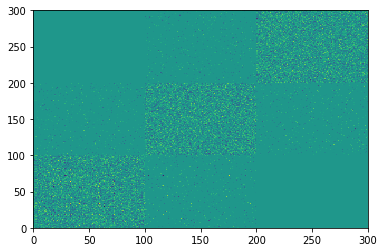

In [3]:
print(rnn.J.shape)
import matplotlib.pyplot as plt
plt.pcolormesh(rnn.J.detach().numpy())
plt.show()

In [10]:

def count(q):
    act = 0
    for x in range(100):
        for y in range(100):
            r = q[x, y]
            if r != 0.0:
                act += 1

    print(act, act / (100 * 100.0))

count(rnn.J[100:200, :100])
count(rnn.J[:100, 100:200])
count(rnn.J[200:300, 100:200])
count(rnn.J[100:200, 200:300])



969 0.0969
948 0.0948
970 0.097
973 0.0973


In [5]:
# Example
# Pick a trial
idx = 1
example_in = network_data['inp'][idx]
print("Input shape:", example_in.shape)
example_out = network_data['targ'][idx]
print("Output shape:", example_out.shape)

pred_out_top = rnn.unroll(torch.tensor(example_in).float())

print("Predicted output shape:", pred_out_top.shape)

Input shape: (21, 286)
Output shape: (50, 286)
Predicted output shape: torch.Size([1, 286, 50])


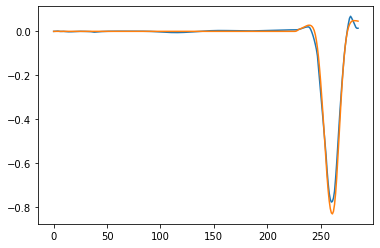

In [6]:
plt.plot(pred_out_top[0,:,17].detach().numpy())
plt.plot(example_out[17,:])
#plt.set_title("Single feature output; pred vs truth")
plt.show()

228.5


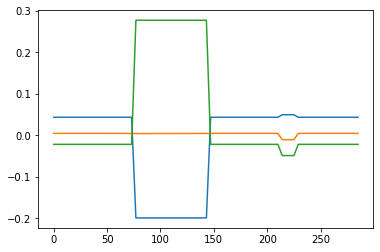

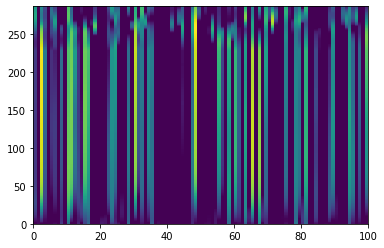

In [7]:
steps = example_in.shape[1]
activations = torch.zeros(steps, rnn.num_neurons)

rnn.reset()

for tidx in range(steps):
    cur_in = torch.tensor(example_in[:, tidx].reshape(example_in.shape[0], 1)).float()
    rnn(cur_in)
    activations[tidx, :] = rnn.prev_output
    
rnn.reset()

hold_sum = sum(example_in[-1, :])
print(hold_sum)

plt.plot(example_in[10, :])
plt.plot(example_in[-2, :])
plt.plot(example_in[0, :])
plt.show()



plt.pcolormesh(activations[:, 0:100].detach().numpy())
plt.show()

ModuleNotFoundError: No module named 'lesion'

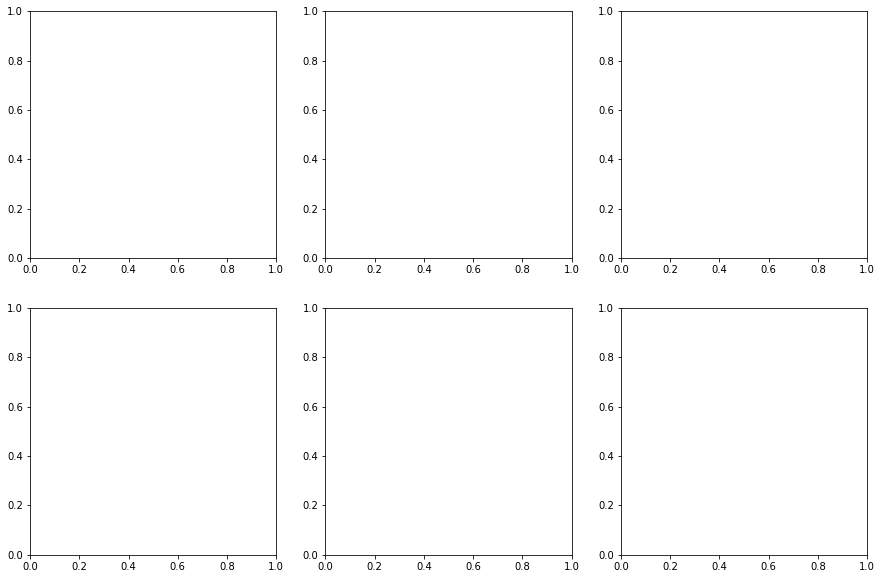

In [8]:
fig,axs = plt.subplots(2,3, figsize=(15,10))
import lesion

# Now apply some lesions
# AIP
lesion_instance = lesion.LesionOutputs(100, 'AIP', 0.75)
rnn.set_lesion(lesion_instance)

rnn.reset_hidden()
pred_out = rnn.unroll(torch.tensor(example_in).float())
axs[0,0].plot(pred_out[0,:,7].detach().numpy())
axs[0,0].plot(example_out[7,:])
axs[0,0].set_title("AIP 75% lesion, TMAJ_l (pulls back shoulder)")
axs[1,0].plot(pred_out[0,:,45].detach().numpy())
axs[1,0].plot(example_out[45,:])
axs[1,0].set_title("AIP 75% lesion, EIP_l (opens index finger)")


# F5
rnn.reset_hidden()
lesion_instance = lesion.LesionOutputs(100, 'F5', 0.75)
rnn.set_lesion(lesion_instance)

# Graph same curve as above
pred_out = rnn.unroll(torch.tensor(example_in).float())
axs[0,1].plot(pred_out[0,:,7].detach().numpy())
axs[0,1].plot(example_out[7,:])
axs[0,1].set_title("F5 75% lesion, TMAJ_l (pulls back shoulder)")
axs[1,1].plot(pred_out[0,:,45].detach().numpy())
axs[1,1].plot(example_out[45,:])
axs[1,1].set_title("F5 75% lesion, EIP_l (opens index finger)")


# M1
rnn.reset_hidden()
lesion_instance = lesion.LesionOutputs(100, 'M1', 0.75)
rnn.set_lesion(lesion_instance)

# Graph same curve as above
pred_out = rnn.unroll(torch.tensor(example_in).float())
axs[0,2].plot(pred_out[0,:,7].detach().numpy())
axs[0,2].plot(example_out[7,:])
axs[0,2].set_title("M1 75% lesion, TMAJ_l (pulls back shoulder)")
axs[1,2].plot(pred_out[0,:,45].detach().numpy())
axs[1,2].plot(example_out[45,:])
axs[1,2].set_title("M1 75% lesion, EIP_l (opens index finger)")

fig.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'lesion'

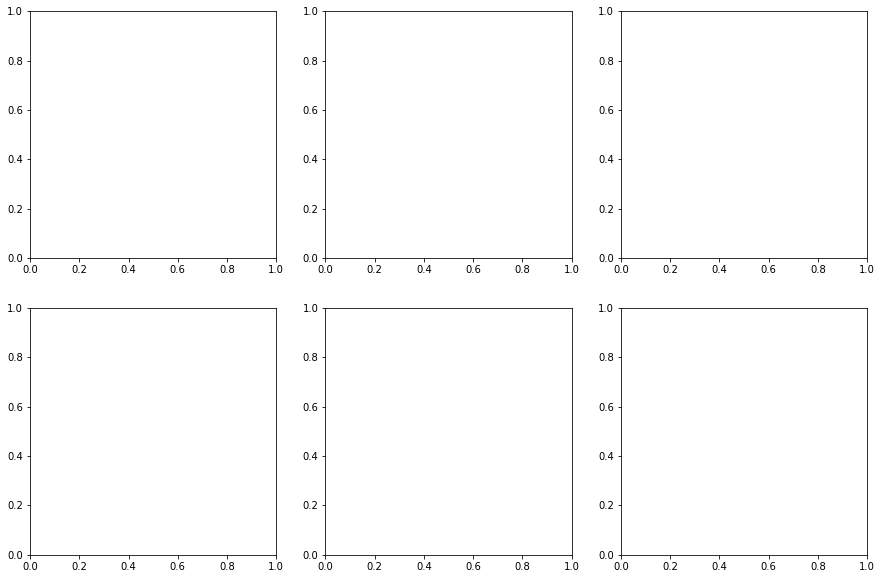

In [9]:
fig,axs = plt.subplots(2,3, figsize=(15,10))
import lesion

# Now apply some lesions
# Disconnect M1 from F5
lesion_instance = lesion.LesionConnectionsByIdxs(100, [(1, 2, 0, 1)])
rnn.set_lesion(lesion_instance)

rnn.reset_hidden()
pred_out = rnn.unroll(torch.tensor(example_in).float())
axs[0,0].plot(pred_out[0,:,7].detach().numpy())
axs[0,0].plot(example_out[7,:])
axs[0,0].set_title("No F5->M1, TMAJ_l (pulls back shoulder)")
axs[1,0].plot(pred_out[0,:,45].detach().numpy())
axs[1,0].plot(example_out[45,:])
axs[1,0].set_title("No F5->M1, EIP_l (opens index finger)")

# Disconnect F5 from M1
rnn.reset_hidden()
lesion_instance = lesion.LesionConnectionsByIdxs(100, [(0, 1, 1, 2)])
rnn.set_lesion(lesion_instance)

# Graph same curve as above
pred_out = rnn.unroll(torch.tensor(example_in).float())
axs[0,1].plot(pred_out[0,:,7].detach().numpy())
axs[0,1].plot(example_out[7,:])
axs[0,1].set_title("No M1->F5, TMAJ_l (pulls back shoulder)")
axs[1,1].plot(pred_out[0,:,45].detach().numpy())
axs[1,1].plot(example_out[45,:])
axs[1,1].set_title("No M1->F5, EIP_l (opens index finger)")


# M1
rnn.reset_hidden()
lesion_instance = lesion.LesionConnectionsByIdxs(100, [(1, 2, 0, 1), (0, 1, 1, 2)])
rnn.set_lesion(lesion_instance)

# Graph same curve as above
pred_out = rnn.unroll(torch.tensor(example_in).float())
axs[0,2].plot(pred_out[0,:,7].detach().numpy())
axs[0,2].plot(example_out[7,:])
axs[0,2].set_title("No F5<->M1, TMAJ_l (pulls back shoulder)")
axs[1,2].plot(pred_out[0,:,45].detach().numpy())
axs[1,2].plot(example_out[45,:])
axs[1,2].set_title("No F5<->M1, EIP_l (opens index finger)")

fig.tight_layout()
plt.show()

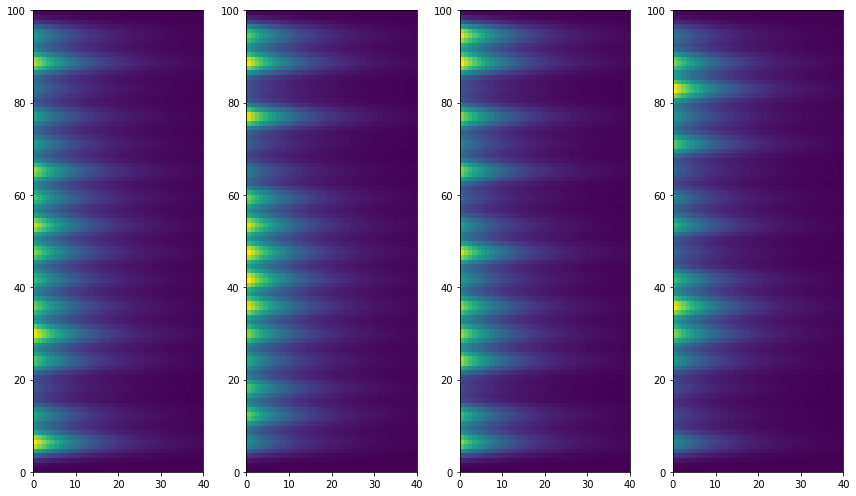

In [10]:
# Stimulation

num_stim_electrodes = 16
fig,axs = plt.subplots(1,4, figsize=(12,7))

stimulus = stim.StimulusGaussianExp(num_stim_electrodes, 100, sigma=1.875, batch_size=4, decay=0.09)
params = torch.tensor(np.array([random.uniform(0.5, 2.5) for _ in range(4 * num_stim_electrodes)]).reshape(
    4, -1)).float()
stimulus.add(params)

stims = [np.zeros((100, 40)) for _ in range(4)]
s = stimulus.get_next()
tidx = 0
while torch.sum(s) > 0.0 and tidx < 40:
    for bidx in range(4):
        stims[bidx][:, tidx] = s[bidx,:100]
    s = stimulus.get_next()
    tidx += 1

for bidx in range(4):
    axs[bidx].pcolormesh(stims[bidx][:,:])

fig.tight_layout()
plt.show()

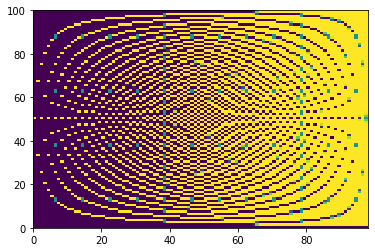

In [18]:
from scipy.stats import norm
dn = norm(0, 0.075)

out = torch.zeros(100, 98).float()
for cidx in range(1, 99):
    cur_stim = stim.StimulusGaussianExp(cidx, 100, sigma=0.075, batch_size=1, decay=0.09)
    aw = cur_stim.get_neuron_weights()
        
    vin = torch.ones(cidx)

    res = aw @ vin
    out[:, cidx-1] = res[:]
    
plt.pcolormesh(out.detach().numpy())

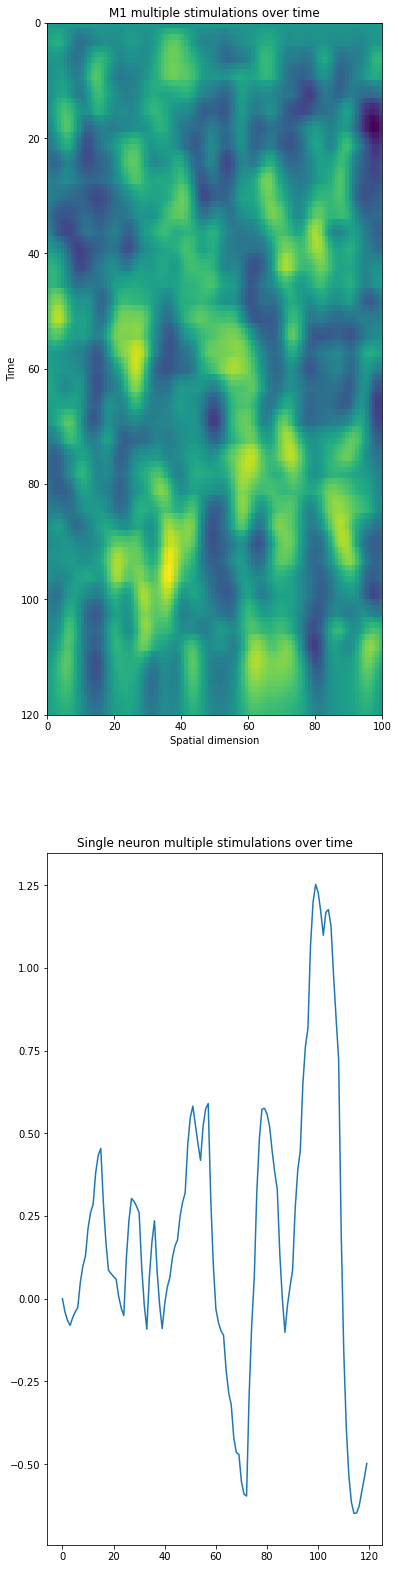

In [20]:
num_stim_electrodes = 64


stims = np.zeros((100,120))
sc = stim.StimulusGaussian(num_stim_electrodes, 100)
sc.reset(batch_size=1)

for tidx in range(120):
    if not (tidx % 3) and tidx < 110:
        params = np.array([random.uniform(-2.5,2.5) for _ in range(num_stim_electrodes)]).reshape(1, num_stim_electrodes)
        sc.add(params)
    stims[:,tidx] = sc.get_next()[0, :100]
    
fig, ax = plt.subplots(2,1, figsize=(6,28))
ax[0].pcolormesh(stims[:100,:].T)
ax[0].set_title("M1 multiple stimulations over time")
ax[0].set_xlabel("Spatial dimension")
ax[0].set_ylabel("Time")
ax[0].set_ylim(ax[0].get_ylim()[::-1])

ax[1].plot(stims[30,:])
ax[1].set_title("Single neuron multiple stimulations over time")

plt.show()

Input shape: (21, 286)
Output shape: (50, 286)
Predicted output shape: torch.Size([1, 286, 50])


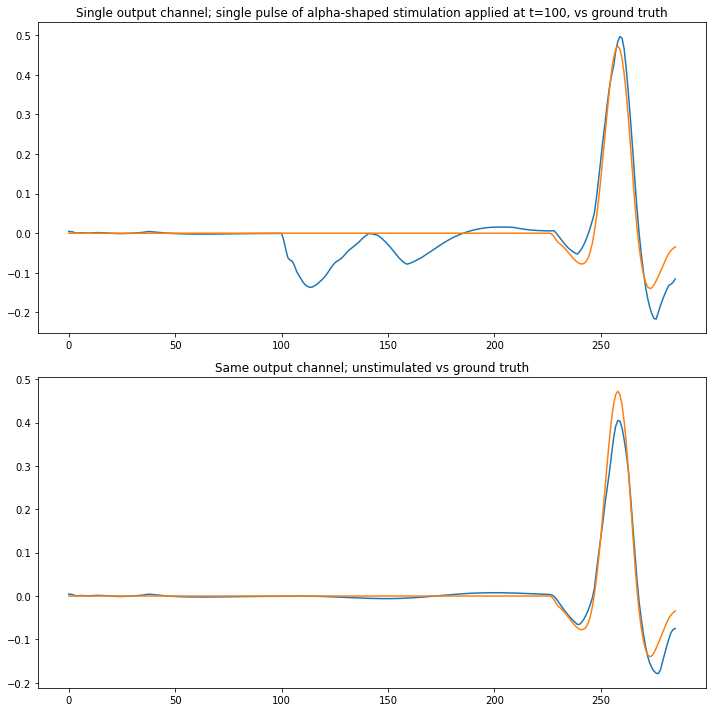

In [22]:
import experiment.observer as observer
sc = stim.StimulusGaussian(num_stim_electrodes, 100)
sc.reset(batch_size=1)
ob = observer.ObserverPassthrough(100)
rnn = mRNN.MichaelsRNN(init_data_path=network_path, stimulus=sc)

idx = 1
example_in = network_data['inp'][idx]
print("Input shape:", example_in.shape)
example_out = network_data['targ'][idx]
print("Output shape:", example_out.shape)

data = utils.fill_jagged_array([example_in,])                                                                                 
steps = data.shape[1]
pred_out = torch.empty((1, steps, rnn.output_dim))
obs = np.zeros((steps,))
for tidx in range(steps):                                                                                                
    
    if tidx == 100:
        params = np.array([random.uniform(-7.5,7.5) for _ in range(num_stim_electrodes)]).reshape(1, -1)
        rnn.stimulate(params)
    cur = data[:,tidx,:] 
    pred_out[0,tidx,:] = rnn(cur.T)
    o = rnn.observe(ob)
    obs[tidx] = o[0][0, 32]

print("Predicted output shape:", pred_out.shape)

fig,axs = plt.subplots(2,1, figsize=(10,10))
axs[0].plot(pred_out[0,:,32].detach().numpy())
axs[1].plot(pred_out_top[0,:,32].detach().numpy())
axs[0].plot(example_out[32,:])
axs[1].plot(example_out[32,:])
axs[0].set_title("Single output channel; single pulse of alpha-shaped stimulation applied at t=100, vs ground truth")
axs[1].set_title("Same output channel; unstimulated vs ground truth")
fig.tight_layout()
plt.show()

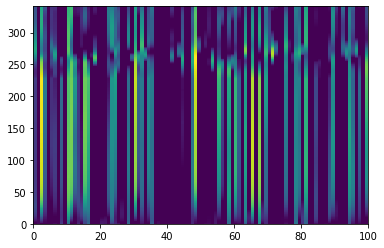

In [27]:
plt.pcolormesh(outputs[:,:100].detach().numpy())
plt.show()

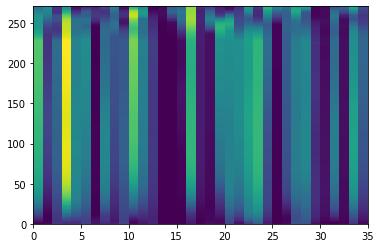

In [117]:
import observer
observer_instance = observer.ObserverGaussian1d(100, 35)

ob = np.zeros((outputs.shape[0], 35))
for tidx in range(outputs.shape[0]):
    ob[tidx, :] = observer_instance(outputs[tidx, :100])
    
plt.pcolormesh(ob[:,:])
plt.show()